In [1]:
import torch
import torchvision
from torchvision import transforms, datasets, models
from torchvision.utils import save_image

from torchviz import make_dot

import torch.optim as optim


import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import math


import os 
import glob
import time
import cv2

from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt

import imageio

In [2]:
torch.cuda.is_available()
device = torch.device("cuda")

In [3]:
#hyperparams

lrD = 0.0002
lrG = 0.0002
bs = 1
loss_fn = nn.BCELoss().to(device)
loss_fn_img = nn.L1Loss().to(device)

In [4]:
class Dsk(nn.Module):
    
    def __init__(self, d=64):
        super(Dsk, self).__init__()
        
        self.conv1 = nn.Conv2d(2, d, 4, 2, 1)
        self.conv2 = nn.Conv2d(d, d * 2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d * 2)
        self.conv3 = nn.Conv2d(d * 2, d * 4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d * 4)
        self.conv4 = nn.Conv2d(d * 4, d * 8, 4, 1, 1)
        self.conv4_bn = nn.BatchNorm2d(d * 8)
        self.conv5 = nn.Conv2d(d * 8, 1, 4, 1, 1)
        
        
        
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
        x = self.conv5(x)

        return torch.sigmoid(x)
    

In [ ]:

'''

#https://github.com/znxlwm/pytorch-pix2pix/blob/master/network.py
#too difficult to follow the whole architecture, i understand what some blocks do

class Generator(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Generator, self).__init__()
        
           
        #reduce to features
        self.c0 = nn.Conv2d(in_channels, 64, 4, stride=2, padding=1)
        self.c1 = nn.Conv2d(64, 128, 4, stride=2, padding=1)
        self.c2 = nn.Conv2d(128, 256, 4, stride=2, padding=1)
        self.c3 = nn.Conv2d(256, 512, 4, stride=2, padding=1)
        self.c4 = nn.Conv2d(512, 512, 4, stride=2, padding=1)
        self.c5 = nn.Conv2d(512, 512, 4, stride=2, padding=1)
        self.c6 = nn.Conv2d(512, 512, 4, stride=2, padding=1)
        self.c7 = nn.Conv2d(512, 512, 4, stride=2, padding=1)
        
        #upsample to image
        self.d7 = nn.ConvTranspose2d(512, 512, 4, stride=2, padding=1)
        self.d6 = nn.ConvTranspose2d(1024, 512, 4, stride=2, padding=1)
        self.d5 = nn.ConvTranspose2d(1024, 512, 4, stride=2, padding=1)
        self.d4 = nn.ConvTranspose2d(1024, 512, 4, stride=2, padding=1)
        self.d3 = nn.ConvTranspose2d(1024, 256, 4, stride=2, padding=1)
        self.d2 = nn.ConvTranspose2d(512, 128, 4, stride=2, padding=1)
        self.d1 = nn.ConvTranspose2d(256, 64, 4, stride=2, padding=1)
        self.d0 = nn.ConvTranspose2d(128, out_channels, 4, stride=2, padding=1)
       
        self.bnc1 = nn.BatchNorm2d(128)
        self.bnc2 = nn.BatchNorm2d(256)
        self.bnc3 = nn.BatchNorm2d(512)
        self.bnc4 = nn.BatchNorm2d(512)
        self.bnc5 = nn.BatchNorm2d(512)
        self.bnc6 = nn.BatchNorm2d(512)

        self.bnd7 = nn.BatchNorm2d(512)
        self.bnd6 = nn.BatchNorm2d(512)
        self.bnd5 = nn.BatchNorm2d(512)
        self.bnd4 = nn.BatchNorm2d(512)
        self.bnd3 = nn.BatchNorm2d(256)
        self.bnd2 = nn.BatchNorm2d(128)
        self.bnd1 = nn.BatchNorm2d(64)
        
        
    def forward(self, x):           
        
        
        en0 = self.c0(x)
        en1 = self.bnc1(self.c1(F.leaky_relu(en0, negative_slope=0.2)))
        en2 = self.bnc2(self.c2(F.leaky_relu(en1, negative_slope=0.2)))
        en3 = self.bnc3(self.c3(F.leaky_relu(en2, negative_slope=0.2)))
        en4 = self.bnc4(self.c4(F.leaky_relu(en3, negative_slope=0.2)))
        en5 = self.bnc5(self.c5(F.leaky_relu(en4, negative_slope=0.2)))
        en6 = self.bnc6(self.c6(F.leaky_relu(en5, negative_slope=0.2)))
        en7 = self.c7(F.leaky_relu(en6, negative_slope=0.2))

        de7 = self.bnd7(self.d7(F.relu(en7)))
        de6 = F.dropout(self.bnd6(self.d6(F.relu(torch.cat((en6, de7),1)))))
        de5 = F.dropout(self.bnd5(self.d5(F.relu(torch.cat((en5, de6),1)))))

        de4 = F.dropout(self.bnd4(self.d4(F.relu(torch.cat((en4, de5),1)))))
        de3 = self.bnd3(self.d3(F.relu(torch.cat((en3, de4),1))))
        de2 = self.bnd2(self.d2(F.relu(torch.cat((en2, de3),1))))
        de1 = self.bnd1(self.d1(F.relu(torch.cat((en1, de2),1))))

        de0 = torch.tanh(self.d0(F.relu(torch.cat((en0, de1),1))))

        return de0
'''

In [8]:
class Generator(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Generator, self).__init__()
        
           
        #reduce to features
        self.c0 = nn.Conv2d(in_channels, 64, 4, stride=2, padding=1)
        self.c1 = nn.Conv2d(64, 128, 4, stride=2, padding=1)
        self.c2 = nn.Conv2d(128, 256, 4, stride=2, padding=1)
        self.c3 = nn.Conv2d(256, 512, 4, stride=2, padding=1)
      
        
        #upsample to image
        
        self.d3 = nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1)
        self.d2 = nn.ConvTranspose2d(512, 128, 4, stride=2, padding=1)
        self.d1 = nn.ConvTranspose2d(256, 64, 4, stride=2, padding=1)
        self.d0 = nn.ConvTranspose2d(128, out_channels, 4, stride=2, padding=1)
       
        self.bnc1 = nn.BatchNorm2d(128)
        self.bnc2 = nn.BatchNorm2d(256)
        self.bnc3 = nn.BatchNorm2d(512)
        

      
        self.bnd3 = nn.BatchNorm2d(256)
        self.bnd2 = nn.BatchNorm2d(128)
        self.bnd1 = nn.BatchNorm2d(64)
        
        
    def forward(self, x):           
                
        en0 = self.c0(x)
        en1 = self.bnc1(self.c1(F.leaky_relu(en0, negative_slope=0.2)))
        en2 = self.bnc2(self.c2(F.leaky_relu(en1, negative_slope=0.2)))
        en3 = self.bnc3(self.c3(F.leaky_relu(en2, negative_slope=0.2)))
        
        de3 = self.bnd3(self.d3(F.relu(en3)))
        de2 = F.dropout(self.bnd2(self.d2(F.relu(torch.cat((en2, de3),1)))))
        de1 = self.bnd1(self.d1(F.relu(torch.cat((en1, de2),1))))

        de0 = torch.tanh(self.d0(F.relu(torch.cat((en0, de1),1))))

        return de0


In [5]:
D = Dsk().to(device)
optimizerD = optim.Adam(D.parameters(), lr=lrD)

In [11]:
torch.flatten(D(torch.ones(1,2, 128, 32).to(device).detach())).shape

torch.Size([28])

In [9]:
G = Generator(1,1).to(device)
optimizerG = optim.Adam(G.parameters(), lr=lrG)

In [12]:
G(torch.ones(1, 1, 128, 32).to(device).detach()).shape

torch.Size([1, 1, 128, 32])

In [9]:
data = torch.tensor(np.load('real_pairs.npy')).float()

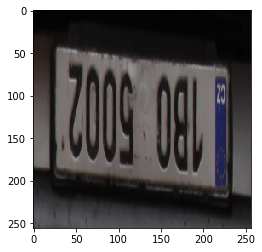

In [10]:
#making sure data is properly formatted
plt.imshow((data[6][:3,:,:].permute(1,2,0).detach().cpu().numpy() + 1)/2) 

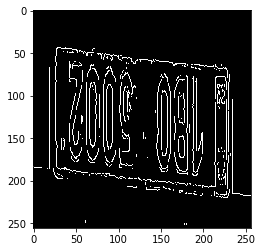

In [35]:
plt.imshow((data[6][3:,:,:].permute(1,2,0).detach().cpu().numpy() + 1)/2) 

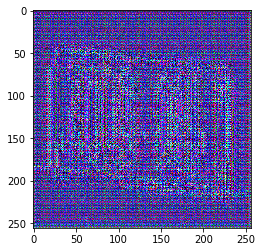

In [13]:
#data passes through generator properly Yay!!!   the motley of functions trailing after G(x) are to adjust for plt.imshow

plt.imshow((G(data[6][3:, :, :].view(-1, 3, 256, 256).to(device)).squeeze(0).permute(1,2,0).detach().cpu().numpy() + 1)/2)

In [17]:
#correct dimensions Dsk output

(D(data[6].view(-1, 6, 256, 256).to(device))).shape

torch.Size([1, 1, 30, 30])

In [44]:
#loss calculations

DskOnReal_loss = loss_fn(torch.flatten(D(data[6].view(-1, 6, 256, 256).to(device))), torch.ones(900).to(device))
print(DskOnReal_loss.data.item())

genImg = G(data[6][3:, :, :].view(-1, 3, 256, 256).to(device))
outlines = data[6][3:, :, :].view(-1, 3, 256, 256).to(device)
fakePair = torch.cat((genImg, outlines), 1)

#see = fakePair.squeeze(0)
#plt.imshow((see[:3,:,:].permute(1,2,0).detach().cpu().numpy() + 1)/2)

DskOnFake_loss = loss_fn(torch.flatten(D(fakePair)), torch.zeros(900).to(device))
print(DskOnFake_loss.data.item())

Dsk_loss = DskOnFake_loss + DskOnReal_loss

#print(fakePair.shape)

Gen_loss = loss_fn(torch.flatten(D(fake)), torch.ones(900).to(device)) + 100*loss_fn_img(fakePair[:,:3,:,:], data[6][:3, :, :].view(-1, 3, 256, 256).to(device))
print(Gen_loss.data.item())

0.6297900676727295
0.7963175177574158
torch.Size([1, 6, 256, 256])
63.26771545410156
